In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT
from metpy.units import units
my_example_nc_file = 'EUREC4A_HALO_BAHAMAS-Radiometer_20200124a.nc'
fh = Dataset(my_example_nc_file, mode='r')
df_fdir = pd.read_csv('BBR_DirectFraction_Flight_20200124a_R0.dat',skiprows = 34,delim_whitespace=True)
df_fdw = pd.read_csv('BBR_Fdn_clear_sky_Flight_20200124a_R0.dat',skiprows = 34, delim_whitespace=True)
#nav = pd.read_csv('Nav_IMS0000_02022020.Asc',skiprows=14, header=None,delim_whitespace=True)
fdw_time = df_fdw.loc[:,['sod','F_dw']]
fdir_time = df_fdir.loc[:,'f_dir']
db = pd.concat([fdw_time,fdir_time],axis=1)
db.set_index('sod',inplace=True)
time = fh.variables['TIME'][:] # time
time_bac = pd.DataFrame(time.T, columns = ['time'])
time_bac = time_bac/1000
time_bac

#print(fh.variables.keys())

,time
0,34171.0
1,34171.1
2,34171.2
3,34171.3
4,34171.4
...,...
331025,67273.5
331026,67273.6
331027,67273.7
331028,67273.8


In [3]:
fdw_time

,sod,F_dw
0,38797,91.973297
1,38917,105.315483
2,39037,119.647255
3,39157,134.789276
4,39277,150.475739
...,...,...
235,67024,680.025207
236,67144,673.512390
237,67264,650.193115
238,67384,642.720520


In [4]:
array = np.arange(38797,70000, 1) #41249 77030  333190 rows × 1 columns
arr = array.repeat(10)
df_arr = pd.DataFrame(arr, columns = ['time_arr'])
df_arr.set_index('time_arr',inplace=True)
data = df_arr.join(db)
data_int= data.interpolate(method='linear', limit_direction='forward', axis=0)
# data_int.drop(data_int.index[0:12089],inplace=True)
data_int.reset_index(inplace=True)
data_int.columns=['time','F_dw','f_dir']  #start:22810,end:355999
#data_int
#data_int[data_int.time==53856.0]
data_int[data_int.time==67274]
df_r = data_int.iloc[0:284779,:]
df_r.reset_index(inplace=True,drop=True)
df_r.drop(['time'],axis=1)

,F_dw,f_dir
0,91.973297,0.856348
1,91.973297,0.856348
2,91.973297,0.856348
3,91.973297,0.856348
4,91.973297,0.856348
...,...,...
284774,649.597064,0.834977
284775,649.590790,0.834974
284776,649.584516,0.834972
284777,649.578242,0.834970


In [5]:
x = df_r.iloc[0:1,:]
df_exp = pd.concat([x]*46251, ignore_index=True)
df = pd.concat([df_exp,df_r],axis=0)
df

,time,F_dw,f_dir
0,38797,91.973297,0.856348
1,38797,91.973297,0.856348
2,38797,91.973297,0.856348
3,38797,91.973297,0.856348
4,38797,91.973297,0.856348
...,...,...,...
284774,67274,649.597064,0.834977
284775,67274,649.590790,0.834974
284776,67274,649.584516,0.834972
284777,67274,649.578242,0.834970


In [6]:
ri = fh.variables['IRS_PHI'][:] # roll angle "deg"
#ro = pd.DataFrame(ri.T)
pi = fh.variables['IRS_THE'][:] # pitch angle "deg"
#po = pd.DataFrame(pi.T)
yi = fh.variables['IRS_HDG'][:] # yaw angle "deg"
#y = pd.DataFrame(yi.T)
szai = fh.variables['SUN_ALT'][:] # solar altitude angle
#sza = pd.DataFrame(szai.T)
saai = fh.variables['SUN_AZI'][:] # solar azimuth angle
#saa = pd.DataFrame(saai.T)
fdw = df.loc[:,'F_dw']
fdir = df.loc[:,'f_dir']
SWd = fh.variables['FDSC'][:]
SWD = pd.DataFrame(SWd.T)
SWD.columns=['swu']
r_off = 0.00027821
p_off = 0.00657381
r = ri+r_off
p = pi+p_off

import math
def Fdw_attitude_correction(fdw,r,p,y,sza,saa,r_off,p_off,fdir):
    for i in szai:
        for j in saai:
            for k in r:
                for l in p:
                    for m in yi:
                        for n in fdw:
                            for o in fdir:
                                eq1 = math.sin((90-i)*(math.pi/180))
                                eq2 = math.cos((90-i)*(math.pi/180))*math.sin(k*(math.pi/180))*math.sin((j-m)*(math.pi/180))
                                eq3 = math.cos((90-i)*(math.pi/180))*math.sin(l*(math.pi/180))
                                eq4 = math.cos(k*(math.pi/180))*math.cos((j-m)*(math.pi/180))
                                eq5 = math.sin((90-i)*(math.pi/180))*math.cos(l*(math.pi/180))*math.cos(k*(math.pi/180))
                                #factor = eq1/((eq2-eq3*(eq4+eq5))
                                factor = eq1/(eq2+(eq3*eq4)+eq5)
                                Fdw=o*n*factor+(1-o)*n
                                return Fdw
correction_weighted = Fdw_attitude_correction(fdw,r,p,yi,szai,saai,r_off,p_off,fdir)
correction_weighted
# corrected_FDSC = SWD.swu + correction_weighted
# swd_correct = pd.DataFrame(corrected_FDSC)
# swd_correct.columns = ['swd_corr']
# swd_correct

93.8165805792263

In [9]:
SWu = fh.variables['FUS'][:]
LWu = fh.variables['FDL'][:]
LWd = fh.variables['FUL'][:]
SWU = pd.DataFrame(SWu.T)
LWU = pd.DataFrame(LWu.T)
LWD = pd.DataFrame(LWd.T)
df_big = pd.concat([time_bac,SWD,swd_correct,SWU,LWU,LWD],axis =1)
df_big.columns = ['Time', 'ShortWave_down','ShortWave_down_corr', 'ShortWave_up','LongWave_down', 'LongWave_up']
df_big['Time'] = df_big.loc[:,'Time'].round(1)
df_big

,Time,ShortWave_down,ShortWave_down_corr,ShortWave_up,LongWave_down,LongWave_up
0,34171.0,-2.132014,91.684566,-5.174749,418.634827,444.084015
1,34171.1,-1.960886,91.855695,-4.587950,429.475891,443.831238
2,34171.2,-2.389399,91.427182,-4.227095,421.098785,443.702026
3,34171.3,-1.657061,92.159520,-4.260000,415.321503,444.217987
4,34171.4,-2.081645,91.734935,-3.812021,421.361786,443.811920
...,...,...,...,...,...,...
331025,67273.5,801.753967,895.570548,59.049152,406.712799,552.671448
331026,67273.6,803.702942,897.519522,57.398262,403.020447,552.907288
331027,67273.7,805.230347,899.046927,55.870483,404.314484,553.833008
331028,67273.8,808.102600,901.919181,53.762821,403.775635,554.767273


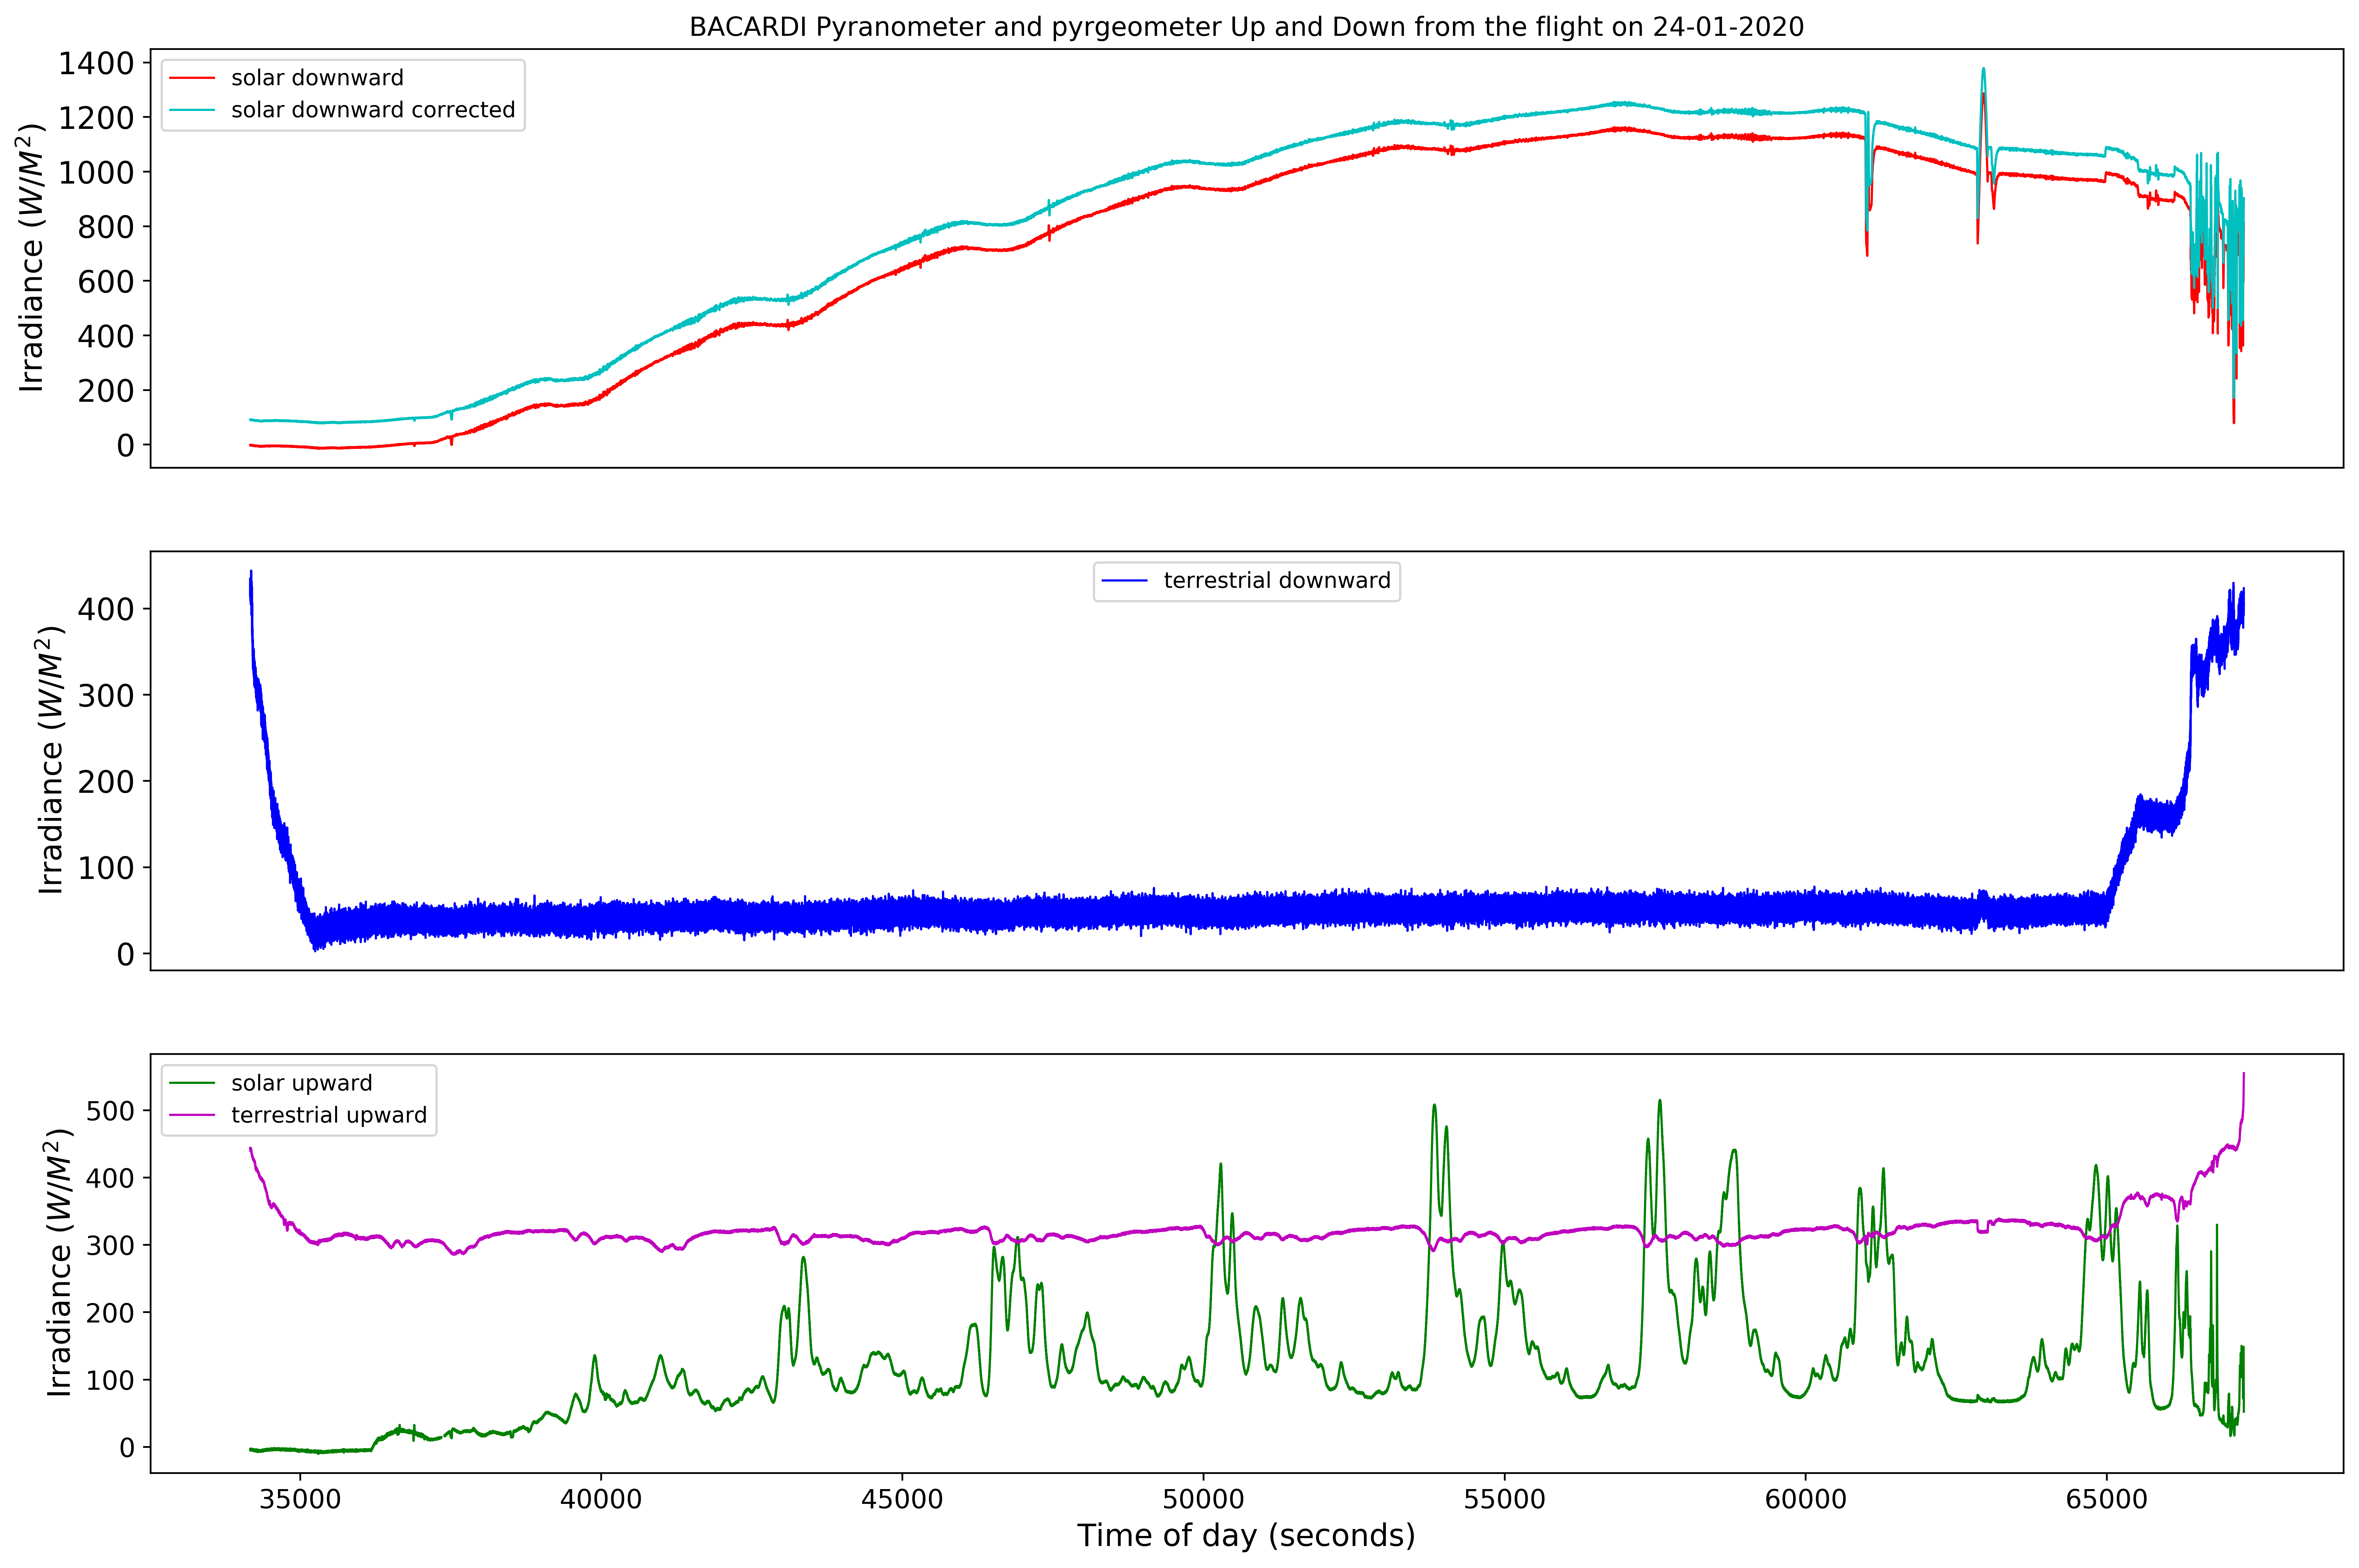

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
#df_new_24jan = pd.read_csv('df_new_24jan.csv')
plt.figure(figsize=(18,12),dpi=500)
plt.subplot(311)
plt.plot(df_big.Time,df_big.ShortWave_down, 'r', label = 'solar downward',linewidth=1)
plt.plot(df_big.Time,df_big.ShortWave_down_corr, 'c', label = 'solar downward corrected',linewidth=1)
plt.title('BACARDI Pyranometer and pyrgeometer Up and Down from the flight on 24-01-2020')
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(312)
plt.plot(df_big.Time,df_big.LongWave_down, 'b', label = 'terrestrial downward',linewidth=1)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xticks([], [])
plt.yticks(fontsize=14)
plt.legend(fontsize=10)
plt.subplot(313)
plt.plot(df_big.Time,df_big.ShortWave_up, 'g', label = 'solar upward',linewidth=1)
plt.plot(df_big.Time,df_big.LongWave_up, 'm', label = 'terrestrial upward',linewidth=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Irradiance ($W/M^2$)',fontsize=14)
plt.xlabel('Time of day (seconds)',fontsize=14)
plt.legend(fontsize=10)
plt.show()

In [66]:
data

,F_dw,f_dir
38797,91.973297,0.856348
38797,91.973297,0.856348
38797,91.973297,0.856348
38797,91.973297,0.856348
38797,91.973297,0.856348
...,...,...
69999,NaN,NaN
69999,NaN,NaN
69999,NaN,NaN
69999,NaN,NaN
